In [7]:
import numpy as np
from numpy import linalg as LA
from ncon import ncon


class DMRGExecutor:
    
    def __init__(self, numsweeps=4, maxit=2, krydim=4, dispon=2, updateon=True):
        self.numsweeps = numsweeps
        self.maxit = maxit
        self.krydim = krydim
        self.dispon = dispon
        self.updateon = updateon
        
        self.initial_state = {
            "numsweeps": numsweeps,
            "maxit": maxit,
            "krydim": krydim,
            "dispon": dispon,
            "updateon": updateon,
        }
    
    def reset(self):
        self.__init__(**self.initial_state)
        
    def __call__(self, mps, left_mpo_bond, mpo_bulk, right_mpo_bond, chi):
        self.mps = mps
        self.left_mpo_bond = left_mpo_bond
        self.mpo_bulk = mpo_bulk
        self.right_mpo_bond = right_mpo_bond
        self.chi = chi
        self.phys_dim = mpo_bulk.shape[2]
        self.n_sites = len(self.mps)
        self.Ekeep = np.array([])
        self.right_mps = [0] * self.n_sites

        self.orthogonalization()

        for k in range(1, self.numsweeps+2):

            ##### final sweep is only for orthogonalization (disable updates)
            if k == self.numsweeps+1:
                self.updateon = False
                self.dispon = 0

            ###### Optimization sweep: right-to-left
            for p in range(self.n_sites-2,-1,-1):
                self.optimization_sweep(p, "right_to_left")
                if self.dispon == 2:
                    print('Sweep: %d of %d, Loc: %d,Energy: %f' % (k, self.numsweeps, p, self.Ekeep[-1]))

            self.compute_bond_tensor("left")

            ###### Optimization sweep: left-to-right
            for p in range(self.n_sites-1):
                self.optimization_sweep(p, "left_to_right")
                if self.dispon == 2:
                    print('Sweep: %d of %d, Loc: %d,Energy: %f' % (k, self.numsweeps, p, self.Ekeep[-1]))

            self.compute_bond_tensor("right")

            if self.dispon == 1:
                print('Sweep: %d of %d, Energy: %12.12d, Bond dim: %d' % (k, self.numsweeps, self.Ekeep[-1], chi))
        
        self.reset()
        
        return self.Ekeep, self.mps, self.sWeight, self.right_mps
    
    def compute_bond_tensor(self, side):
        if side == "left":
            chil = self.mps[0].shape[0]; chir = self.mps[0].shape[2]
            Atemp = ncon([self.mps[0], self.sWeight[1]], [[-1,-2,1],[1,-3]]).reshape(chil, self.phys_dim*chir)
            utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
            self.right_mps[0] = vhtemp.reshape(chil, self.phys_dim, chir)
            self.sWeight[0] = utemp @ (np.diag(stemp)/LA.norm(stemp))
            
        elif side == "right":
            chil = self.right_mps[self.n_sites-1].shape[0]; chir = self.right_mps[self.n_sites-1].shape[2]
            Atemp = ncon([self.right_mps[self.n_sites-1],self.sWeight[self.n_sites-1]],[[1,-2,-3],[-1,1]]).reshape(chil*self.phys_dim, chir)
            utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
            self.mps[self.n_sites-1] = utemp.reshape(chil, self.phys_dim, chir)
            self.sWeight[self.n_sites] = (stemp/LA.norm(stemp))*vhtemp

    def doApplyMPO(self, psi, p):
        """ function for applying MPO to state """
        psi_reshaped = psi.reshape(self.left_mpo[p].shape[2], self.mpo_bulk.shape[3],
                                 self.mpo_bulk.shape[3], self.right_mpo[p+1].shape[2])
        
        return ncon([psi_reshaped, self.left_mpo[p], self.mpo_bulk, self.mpo_bulk, self.right_mpo[p+1]],
                    [[1,3,5,7],[2,-1,1],[2,4,-2,3],[4,6,-3,5],[6,-4,7]]).ravel()

    def eigLanczos(self, p):
        """ Lanczos method for finding smallest algebraic eigenvector of linear \
        operator defined as a function"""
        if LA.norm(self.psiGround) == 0:
            self.psiGround = np.random.rand(len(self.psiGround))

        psi = np.zeros([len(self.psiGround), self.krydim+1])
        A = np.zeros([self.krydim, self.krydim])
        dval = 0

        for ik in range(self.maxit):

            psi[:,0] = self.psiGround/max(LA.norm(self.psiGround),1e-16)
            for ip in range(1, self.krydim+1):

                psi[:,ip] = self.doApplyMPO(psi[:,ip-1], p)

                for ig in range(ip):
                    A[ip-1,ig] = np.dot(psi[:,ip],psi[:,ig])
                    A[ig,ip-1] = np.conj(A[ip-1,ig])

                for ig in range(ip):
                    psi[:,ip] = psi[:,ip] - np.dot(psi[:,ig],psi[:,ip])*psi[:,ig]
                    psi[:,ip] = psi[:,ip] / max(LA.norm(psi[:,ip]),1e-16)

            [dtemp,utemp] = LA.eigh(A)
            self.psiGround = psi[:,range(0, self.krydim)] @ utemp[:,0]

        self.psiGround = self.psiGround/LA.norm(self.psiGround)
        dval = dtemp[0]

        return dval
    
    def orthogonalization(self):
        ##### left-to-right 'warmup', put MPS in right orthogonal form
        self.left_mpo = [0 for x in range(self.n_sites)]; self.left_mpo[0] = self.left_mpo_bond
        self.right_mpo = [0 for x in range(self.n_sites)]; self.right_mpo[self.n_sites-1] = self.right_mpo_bond
        
        for p in range(self.n_sites-1):
            chil = self.mps[p].shape[0]; chir = self.mps[p].shape[2]
            utemp, stemp, vhtemp = LA.svd(self.mps[p].reshape(chil*self.phys_dim, chir), full_matrices=False)
            self.mps[p] = utemp.reshape(chil, self.phys_dim, chir)
            self.mps[p+1] = ncon([np.diag(stemp) @ vhtemp, self.mps[p+1]], [[-1,1],[1,-2,-3]])/LA.norm(stemp)
            self.left_mpo[p+1] = ncon([self.left_mpo[p], mpo_bulk, self.mps[p], np.conj(self.mps[p])],
                                      [[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])

        chil = self.mps[self.n_sites-1].shape[0]; chir = self.mps[self.n_sites-1].shape[2]
        utemp, stemp, vhtemp = LA.svd(self.mps[self.n_sites-1].reshape(chil*self.phys_dim, chir), full_matrices=False)
        self.mps[self.n_sites-1] = utemp.reshape(chil, self.phys_dim, chir)
        self.sWeight = [0 for x in range(self.n_sites+1)]
        self.sWeight[self.n_sites] = (np.diag(stemp) @ vhtemp) / LA.norm(stemp)
    
    def optimization_sweep(self, p, direction):
        ###### Optimization sweep step
        ##### two-site update
        if direction == "right_to_left":
            chil = self.mps[p].shape[0]; chir = self.mps[p+1].shape[2]
            self.psiGround = ncon([self.mps[p], self.mps[p+1], self.sWeight[p+2]],
                             [[-1,-2,1],[1,-3,2],[2,-4]]).ravel()
            
        elif direction == "left_to_right":
            chil = self.right_mps[p].shape[0]; chir = self.right_mps[p+1].shape[2]
            self.psiGround = ncon([self.sWeight[p], self.right_mps[p], self.right_mps[p+1]],
                             [[-1,1],[1,-2,2],[2,-3,-4]]).ravel()
            
        if self.updateon:
            Entemp = self.eigLanczos(p)
            self.Ekeep = np.append(self.Ekeep,Entemp)

        utemp, stemp, vhtemp = LA.svd(self.psiGround.reshape(chil*self.phys_dim, self.phys_dim*chir), full_matrices=False)
        chitemp = min(len(stemp),chi)
        self.mps[p] = utemp[:,range(chitemp)].reshape(chil, self.phys_dim, chitemp)
        self.sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
        self.right_mps[p+1] = vhtemp[range(chitemp),:].reshape(chitemp, self.phys_dim, chir)

        ##### new block Hamiltonian
        if direction == "right_to_left":
            self.right_mpo[p] = ncon([mpo_bulk, self.right_mpo[p+1], self.right_mps[p+1], np.conj(self.right_mps[p+1])],
                                     [[-1,2,3,5],[2,1,4],[-3,5,4],[-2,3,1]])
            
        elif direction == "left_to_right":
            self.left_mpo[p+1] = ncon([self.left_mpo[p], mpo_bulk, self.mps[p], np.conj(self.mps[p])],
                                  [[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])


Sweep: 1 of 3, Loc: 48,Energy: 39.608931
Sweep: 1 of 3, Loc: 47,Energy: 36.133669
Sweep: 1 of 3, Loc: 46,Energy: 31.464480
Sweep: 1 of 3, Loc: 45,Energy: 29.402818
Sweep: 1 of 3, Loc: 44,Energy: 26.181122
Sweep: 1 of 3, Loc: 43,Energy: 24.604037
Sweep: 1 of 3, Loc: 42,Energy: 22.420603
Sweep: 1 of 3, Loc: 41,Energy: 20.002213
Sweep: 1 of 3, Loc: 40,Energy: 17.527794
Sweep: 1 of 3, Loc: 39,Energy: 15.339880
Sweep: 1 of 3, Loc: 38,Energy: 12.865729
Sweep: 1 of 3, Loc: 37,Energy: 11.064670
Sweep: 1 of 3, Loc: 36,Energy: 8.105811
Sweep: 1 of 3, Loc: 35,Energy: 6.381092
Sweep: 1 of 3, Loc: 34,Energy: 4.231520
Sweep: 1 of 3, Loc: 33,Energy: 2.615299
Sweep: 1 of 3, Loc: 32,Energy: 0.000071
Sweep: 1 of 3, Loc: 31,Energy: -2.671685
Sweep: 1 of 3, Loc: 30,Energy: -4.234833
Sweep: 1 of 3, Loc: 29,Energy: -7.609668
Sweep: 1 of 3, Loc: 28,Energy: -8.875914
Sweep: 1 of 3, Loc: 27,Energy: -11.323944
Sweep: 1 of 3, Loc: 26,Energy: -13.334369
Sweep: 1 of 3, Loc: 25,Energy: -15.855165
Sweep: 1 of 3, Loc

Sweep: 3 of 3, Loc: 42,Energy: -62.944284
Sweep: 3 of 3, Loc: 41,Energy: -62.944283
Sweep: 3 of 3, Loc: 40,Energy: -62.944290
Sweep: 3 of 3, Loc: 39,Energy: -62.944287
Sweep: 3 of 3, Loc: 38,Energy: -62.944297
Sweep: 3 of 3, Loc: 37,Energy: -62.944291
Sweep: 3 of 3, Loc: 36,Energy: -62.944304
Sweep: 3 of 3, Loc: 35,Energy: -62.944295
Sweep: 3 of 3, Loc: 34,Energy: -62.944311
Sweep: 3 of 3, Loc: 33,Energy: -62.944298
Sweep: 3 of 3, Loc: 32,Energy: -62.944316
Sweep: 3 of 3, Loc: 31,Energy: -62.944301
Sweep: 3 of 3, Loc: 30,Energy: -62.944321
Sweep: 3 of 3, Loc: 29,Energy: -62.944304
Sweep: 3 of 3, Loc: 28,Energy: -62.944325
Sweep: 3 of 3, Loc: 27,Energy: -62.944306
Sweep: 3 of 3, Loc: 26,Energy: -62.944327
Sweep: 3 of 3, Loc: 25,Energy: -62.944308
Sweep: 3 of 3, Loc: 24,Energy: -62.944329
Sweep: 3 of 3, Loc: 23,Energy: -62.944308
Sweep: 3 of 3, Loc: 22,Energy: -62.944329
Sweep: 3 of 3, Loc: 21,Energy: -62.944308
Sweep: 3 of 3, Loc: 20,Energy: -62.944328
Sweep: 3 of 3, Loc: 19,Energy: -62

Sweep: 2 of 3, Loc: 32,Energy: -62.945475
Sweep: 2 of 3, Loc: 31,Energy: -62.945475
Sweep: 2 of 3, Loc: 30,Energy: -62.945475
Sweep: 2 of 3, Loc: 29,Energy: -62.945475
Sweep: 2 of 3, Loc: 28,Energy: -62.945475
Sweep: 2 of 3, Loc: 27,Energy: -62.945475
Sweep: 2 of 3, Loc: 26,Energy: -62.945475
Sweep: 2 of 3, Loc: 25,Energy: -62.945475
Sweep: 2 of 3, Loc: 24,Energy: -62.945475
Sweep: 2 of 3, Loc: 23,Energy: -62.945475
Sweep: 2 of 3, Loc: 22,Energy: -62.945475
Sweep: 2 of 3, Loc: 21,Energy: -62.945475
Sweep: 2 of 3, Loc: 20,Energy: -62.945475
Sweep: 2 of 3, Loc: 19,Energy: -62.945475
Sweep: 2 of 3, Loc: 18,Energy: -62.945475
Sweep: 2 of 3, Loc: 17,Energy: -62.945475
Sweep: 2 of 3, Loc: 16,Energy: -62.945475
Sweep: 2 of 3, Loc: 15,Energy: -62.945475
Sweep: 2 of 3, Loc: 14,Energy: -62.945474
Sweep: 2 of 3, Loc: 13,Energy: -62.945474
Sweep: 2 of 3, Loc: 12,Energy: -62.945474
Sweep: 2 of 3, Loc: 11,Energy: -62.945474
Sweep: 2 of 3, Loc: 10,Energy: -62.945474
Sweep: 2 of 3, Loc: 9,Energy: -62.

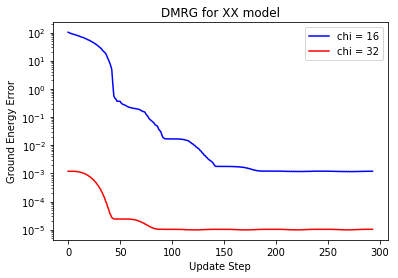

In [8]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline

from ncon import ncon
from mpsutil import XXInitializer, VariableBondStateInit

##### XX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 16;
n_sites = 50;

numsweeps = 3 # number of DMRG sweeps
maxit = 2 # iterations of Lanczos method
krydim = 4 # dimension of Krylov subspace

#### Define quantum XX model
phys_dim = 2
hamiltonian_bond_dim = 4

mpo_init = XXInitializer(n_sites, hamiltonian_bond_dim, phys_dim) 
left_mpo_bond, mpo_bulk, right_mpo_bond = mpo_init()

dmrg = DMRGExecutor(numsweeps=numsweeps, maxit=maxit, krydim=krydim)

mps_init = VariableBondStateInit(n_sites, phys_dim, phys_dim)
mps = mps_init(chi)

#### Do DMRG sweeps (2-site approach)
En1, A, sWeight, B = dmrg(mps, left_mpo_bond, mpo_bulk, right_mpo_bond, chi)

#### Increase bond dim and reconverge
chi = 32

#mps_init = VariableBondStateInit(n_sites, min(chi, phys_dim), phys_dim)
#mps = mps_init(chi)

En2, A, sWeight, B = dmrg(mps, left_mpo_bond, mpo_bulk, right_mpo_bond, chi)

#### Compare with exact results (computed from free fermions)
H = np.diag(np.ones(n_sites-1),k=1) + np.diag(np.ones(n_sites-1),k=-1)
D = LA.eigvalsh(H)
EnExact = 2*sum(D[D < 0])

##### Plot results
print("="*41)
print("MPO bulk:")
print(mpo_init)
plt.figure(1)
plt.yscale('log')
plt.plot(range(len(En1)), En1 - EnExact, 'b', label="chi = 16")
plt.plot(range(len(En2)), En2 - EnExact, 'r', label="chi = 32")
plt.legend()
plt.title('DMRG for XX model')
plt.xlabel('Update Step')
plt.ylabel('Ground Energy Error')
plt.show()
